In [53]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  

In [54]:
series = pd.read_excel('Airlines_Data.xlsx', header=0, index_col=0, parse_dates=True)   

In [55]:
series  

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


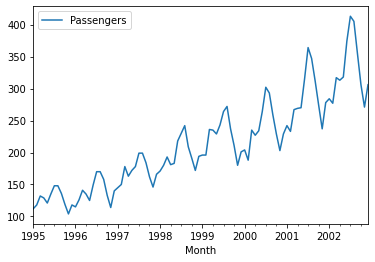

In [56]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()  

array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

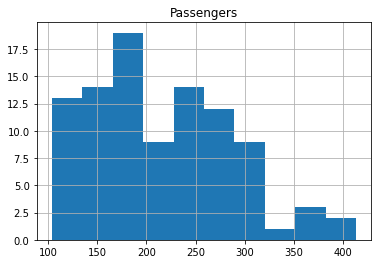

In [57]:
series.hist()  

<AxesSubplot:ylabel='Density'>

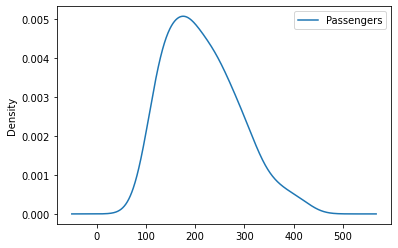

In [58]:
series.plot(kind='kde')  

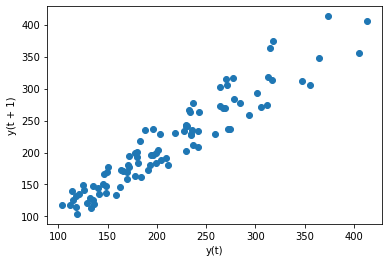

In [59]:
# Lag plot
# create a scatter plot
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

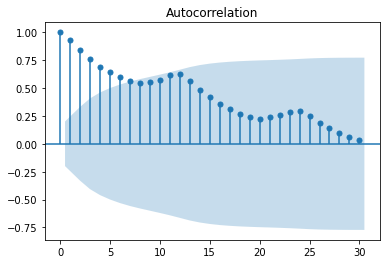

In [60]:
# create an autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series,lags=30)
pyplot.show()

In [61]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)  

Dataset 86, Validation 10


#### Persistence/ Base model

In [62]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]  


In [63]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse) 

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

#### ARIMA Hyperparameters

In [64]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse  

#### Grid search for p,d,q values

In [65]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))  

In [66]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)   

ARIMA(0, 0, 0) RMSE=78.563
ARIMA(0, 0, 1) RMSE=44.789
ARIMA(0, 1, 0) RMSE=25.903
ARIMA(0, 1, 1) RMSE=25.355
ARIMA(0, 1, 2) RMSE=27.772
ARIMA(0, 2, 0) RMSE=32.474
ARIMA(0, 2, 1) RMSE=26.640
ARIMA(0, 2, 2) RMSE=25.942
ARIMA(1, 0, 0) RMSE=26.036
ARIMA(1, 0, 1) RMSE=25.282
ARIMA(1, 0, 2) RMSE=443.424
ARIMA(1, 1, 0) RMSE=25.679
ARIMA(1, 2, 0) RMSE=31.603
ARIMA(2, 0, 0) RMSE=25.620
ARIMA(2, 1, 0) RMSE=25.467
ARIMA(2, 2, 0) RMSE=30.414
Best ARIMA(1, 0, 1) RMSE=25.282


#### Build Model based on the optimized values

In [67]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy 

In [68]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32') 

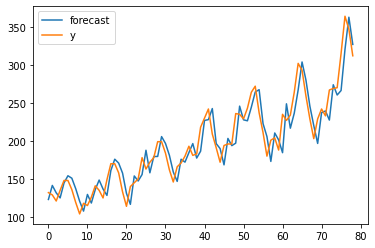

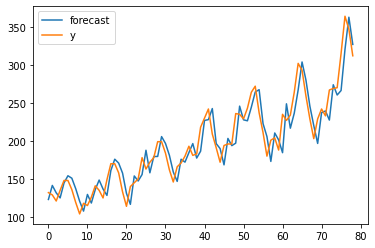

In [69]:
# fit model
model = ARIMA(X, order=(1,0,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 79) 

In [70]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse 

102.54609088423197

#### Combine train and test data and build final model

In [71]:
# fit model
data = pd.read_excel('Airlines_Data.xlsx', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32') 

In [72]:
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit() 

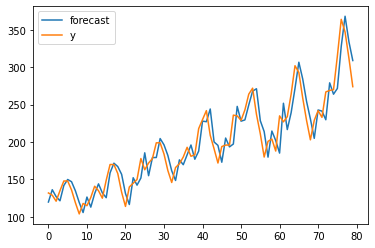

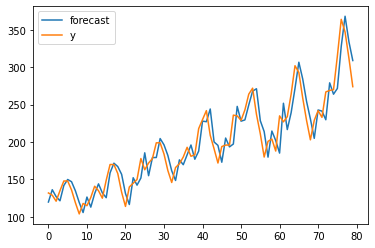

In [73]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,80) 

In [74]:
forecast 

array([275.82214604, 278.89229173, 281.74309546, 283.61903121,
       285.30317381, 287.15159008, 289.08192169, 290.99674868,
       292.8900088 , 294.78133541])